# Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Packages.data import load_csv_to_dataframe, plot_roc_curve, plot_feature_importance # show_tree,
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, mean_squared_error

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


### Load data from Packages.data

In [2]:
file = '../Data/data.csv'
df = load_csv_to_dataframe(file)
print(df.columns)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Churn_cat',
       'tenure_cat', 'MonthlyCharges_cat', 'TotalCharges_cat'],
      dtype='object')


### Prepare dataframe for train, validation, test split

* 'customerID': drop. A random string assigned to each customer.
* 'tenure'    : drop. A categorical feature was created for this.
* 'MonthlyCharges' : drop. A categorical feature was created for this.
* 'TotalCharges'   : drop. A categorical feature ...
* 'Churn'          : drop. The label is dropped from the X_train, X_test, X_valid datasets

The 'X' dataframe is then one hot encoded via pandas.get_dummies()

In [3]:
X = df.drop(['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Churn_cat'], axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df['Churn_cat']

In [4]:
df['Churn'].value_counts(), df['Churn'].value_counts()/ len(df)

(No     5163
 Yes    1869
 Name: Churn, dtype: int64,
 No     0.734215
 Yes    0.265785
 Name: Churn, dtype: float64)

In [5]:
df['Churn_cat'].value_counts()

0    5163
1    1869
Name: Churn_cat, dtype: int64

### Split data into training, validation and test

The full dataset is split into three parts (training, test, validation).  

Stratified splits due to the unequal partitioning of the dataset (No: 5163 (73%), Yes: 1869 (27%))

In [4]:
def train_test_valid(X, y):
    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, test_size=0.2,  random_state=42)
    return X_train, X_test, X_valid, y_train, y_test, y_valid

In [6]:
# X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, test_size=0.2,  random_state=42)

In [5]:
X_train, X_test, X_valid, y_train, y_test, y_valid = train_test_valid(X, y)

In [6]:
print(f"Dataframe: {df.shape}, X.shape: {X.shape}, y.shape: {y.shape}")
print(f"training shape: {X_train.shape}, validiation shape: {X_valid.shape}, testing shape: {X_test.shape}")
print(f"training labels: {y_train.shape}, validation shape: {y_valid.shape}, testing labels: {y_test.shape}")

Dataframe: (7032, 25), X.shape: (7032, 30), y.shape: (7032,)
training shape: (4500, 30), validiation shape: (1125, 30), testing shape: (1407, 30)
training labels: (4500,), validation shape: (1125,), testing labels: (1407,)


### Create DecisionTreeClassifier, fit and predict

The assignment is to compare a Decision Tree classifier with Random Forest

In [7]:
# From the future....
# Best params: {'max_depth': 5, 'max_features': 30, 'max_leaf_nodes': 10, 'min_samples_split': 3}
tree_clf = DecisionTreeClassifier(max_depth=5, max_features=30, max_leaf_nodes=10, min_samples_split=3)
tree_clf.fit(X_train, y_train)
y_predict = tree_clf.predict(X_test)

In [8]:
print(f"Accuracy on training set: {tree_clf.score(X_train, y_train):.4f}")
print(f"Accuracy on test set:     {tree_clf.score(X_test, y_test):.4f}")

Accuracy on training set: 0.8578
Accuracy on test set:     0.8586


### Accuracy of train / test

Accuracy reports how many correct out of total.  This can be misleading if the dataset is very highly skewed.  In this case predictions of only 1 (no churn) will score above 70%!

In [9]:
from sklearn.base import BaseEstimator
class NeverChurnClassifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_churn_clf = NeverChurnClassifier()
cross_val_score(never_churn_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.73066667, 0.75133333, 0.72066667])

### Cross-Validation

Cross-Validation predictions based on default DecisionTreeClassifer() (tree_clf)

In [10]:
y_predict_cv = cross_val_predict(tree_clf, X_train, y_train, cv=5)

### Confusion matrix results for predict and cross-val predict

In [11]:
# Confusion Matrix results
print(confusion_matrix(y_test, y_predict))
print(confusion_matrix(y_train, y_predict_cv))

[[966  67]
 [132 242]]
[[3089  215]
 [ 449  747]]


### Classification Report

Classification report for a 'straight' Decision Tree classifier and one for a Cross-Validation (5-fold).

In [12]:
print(classification_report(y_test, y_predict))
print(classification_report(y_train, y_predict_cv))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1033
           1       0.78      0.65      0.71       374

    accuracy                           0.86      1407
   macro avg       0.83      0.79      0.81      1407
weighted avg       0.85      0.86      0.85      1407

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      3304
           1       0.78      0.62      0.69      1196

    accuracy                           0.85      4500
   macro avg       0.82      0.78      0.80      4500
weighted avg       0.85      0.85      0.85      4500



In [13]:
# Precision, Recall and F1 Scores
print("Precision, Recall, F1 scores for Churn=yes")
print("="*42)
print(f"Precision: {precision_score(y_test, y_predict):.4f}")
print(f"Recall: {recall_score(y_test, y_predict):.4f}")
print(f"F1: {f1_score(y_test, y_predict):.4f}")
print('*'*8 + "Cross-Validation "+'*'*8)
print(f"Precision (cv): {precision_score(y_train, y_predict_cv):.4f}")
print(f"Recall (cv): {recall_score(y_train, y_predict_cv):.4f}")
print(f"F1 (cv): {f1_score(y_train, y_predict_cv):.4f}")

Precision, Recall, F1 scores for Churn=yes
Precision: 0.7832
Recall: 0.6471
F1: 0.7086
********Cross-Validation ********
Precision (cv): 0.7765
Recall (cv): 0.6246
F1 (cv): 0.6923


### ROC Curve

In [14]:
# Compute y scores for input to metrics
y_probas = cross_val_predict(tree_clf, X_train, y_train, cv=5, method='predict_proba')  # method='decision_function'
y_scores = y_probas[:, 1]

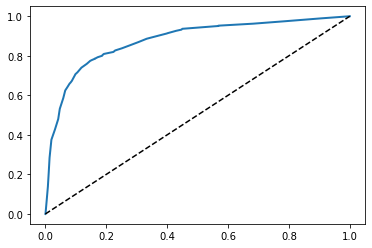

In [15]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
plot_roc_curve(fpr, tpr)

### ROC AUC

The Area Under Curve (AUC) returns ...

In [16]:
# ROC AUC Curve
print(f"ROC AUC: {roc_auc_score(y_train, y_scores):.4f}")

ROC AUC: 0.8781


### Comment on ROC and AUC

* Score of 0.8831 on Area under the curve => 

### Feature Importance

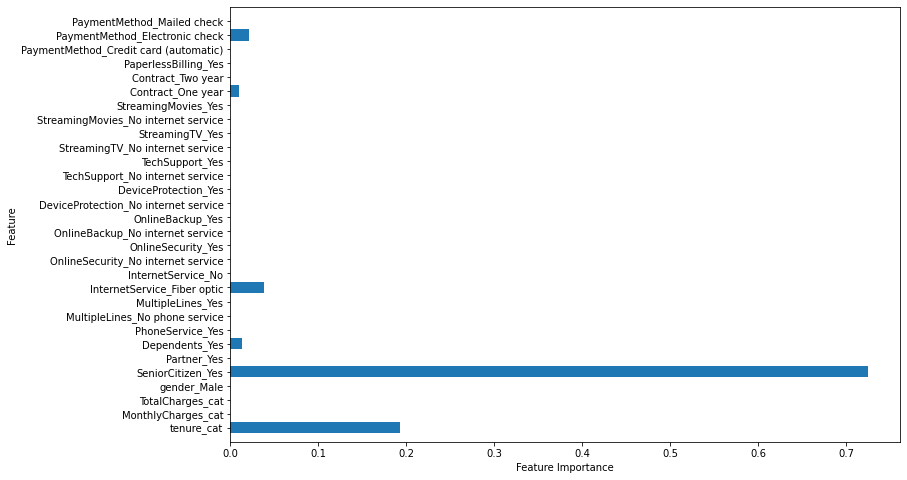

In [17]:
# print(f"Feature importances:\n{tree_clf.feature_importances_}")

plot_feature_importance(X, tree_clf)

### Comment on Feature Importance

tree_clf = DecisionTreeClassifier(max_depth=5, max_features=30, max_leaf_nodes=10, min_samples_split=3)

* The Decision Tree classifier was created with max_features set to 30.  
* The model uses ? features (5?). 
* The first split is at Senior Citizen.  
* What is the 'gini' and purity, etc ?

## Training Set Size on Error Stability

In [81]:
def train_test_valid(X, y):
    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, test_size=0.2,  random_state=42)
    return X_train, X_test, X_valid, y_train, y_test, y_valid

In [51]:
def train_test(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #  , stratify=y, random_state=42
    return X_train, X_test, y_train, y_test

In [62]:
def plot_learning_curves(model, X, y):
    X_train, X_test, y_train, y_test = train_test(X, y)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_predict = model.predict(X_train[:m])
        y_valid_predict = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_predict))
        val_errors.append(mean_squared_error(y_test, y_valid_predict))
    plt.plot(np.sqrt(train_errors), "r-+", lw=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", lw=3, label='validation')

In [84]:
def plot_learning_curves(model, X, y):
    X_train, X_test, X_valid, y_train, y_test, y_valid = train_test_valid(X, y)
    train_errors, test_errors, val_errors = [], [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_predict = model.predict(X_train[:m])
        y_test_predict = model.predict(X_test)
        y_valid_predict = model.predict(X_valid)
        train_errors.append(mean_squared_error(y_train[:m], y_predict))
        test_errors.append(mean_squared_error(y_test, y_test_predict))
        val_errors.append(mean_squared_error(y_valid, y_valid_predict))
    
    plt.plot(np.sqrt(train_errors), "r-+", lw=1, label="train")
    plt.plot(np.sqrt(test_errors), "g--", lw=2, label="test")
    plt.plot(np.sqrt(val_errors), "b-", lw=2, label='validation')
    

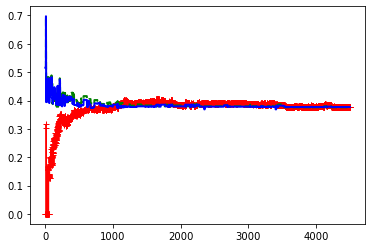

In [85]:
model_clf = DecisionTreeClassifier(max_depth=5, max_features=30, max_leaf_nodes=10, min_samples_split=3)
plot_learning_curves(model_clf, X, y)

(7032, 30) (5625, 30) (1407, 30) (7032,) (5625,) (1407,)


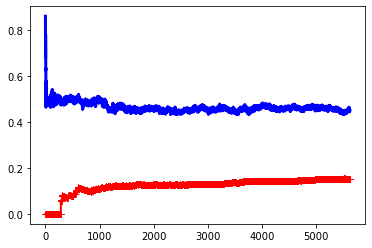

In [64]:
model_clf = DecisionTreeClassifier()
plot_learning_curves(model_clf, X, y)

(7032, 30) (5625, 30) (1407, 30) (7032,) (5625,) (1407,)


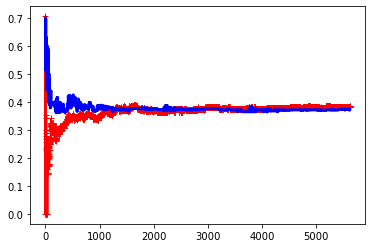

In [63]:
model_clf = DecisionTreeClassifier(max_depth=5, max_features=30, max_leaf_nodes=10, min_samples_split=3)
plot_learning_curves(model_clf, X, y)

## Grid Search CV : Decision Tree Classifier

Consider exploring the following parameters...

* 'criterion' : ['gini', 'entropy']
* 'max_depth' :
* 'min_samples_split' :
* 'min_samples_leaf' :
* 'max_features' :
* 'max_leaf_nodes' :

In [19]:
# Grid Search CV
from sklearn.model_selection import GridSearchCV
params = {'max_depth' : [2, 5, 10, 20],
          'min_samples_split': [3, 10, 30],
          'max_leaf_nodes': [3, 10, 30],
          'max_features': [3, 10, 30]}
# 
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=5)
grid_search_cv.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:    4.1s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [2, 5, 10, 20],
                         'max_features': [3, 10, 30],
                         'max_leaf_nodes': [3, 10, 30],
                         'min_samples_split': [3, 10, 30]},
             verbose=1)

### Grid Search CV: best score, best parameters

In [20]:
print(f"Grid search CV, best estimator: {grid_search_cv.best_estimator_}")
print(f"Best score: {grid_search_cv.best_params_}")
print(f"Best params: {grid_search_cv.best_params_}")
print(f"Best index: {grid_search_cv.best_index_}")

Grid search CV, best estimator: DecisionTreeClassifier(max_depth=5, max_features=30, max_leaf_nodes=10,
                       min_samples_split=3, random_state=42)
Best score: {'max_depth': 5, 'max_features': 30, 'max_leaf_nodes': 10, 'min_samples_split': 3}
Best params: {'max_depth': 5, 'max_features': 30, 'max_leaf_nodes': 10, 'min_samples_split': 3}
Best index: 48


### Grid Search CV: best parameters for Validation

In [21]:
# find best parameters from fit on X_train, y_train
best_params = grid_search_cv.best_params_
# Instantiate Decision Tree Classifier from those best parameters
tree_clf_bp = DecisionTreeClassifier(**best_params)
# Fit Classifier on Validation set
tree_clf_bp.fit(X_valid, y_valid)
# check on test set
bp_score = tree_clf_bp.score(X_test, y_test)

In [62]:
y_predict_bp = tree_clf_bp.predict(X_test)
#y_predict_bp.shape

results = pd.DataFrame(grid_search_cv.cv_results_)
print(results.shape)
# results.head()

(108, 17)


In [23]:
cvrs = grid_search_cv.cv_results_
for mean_score, params in zip(cvrs['mean_test_score'], cvrs['params']):
    print(np.sqrt(mean_score), params)

0.857092239201155 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 3, 'min_samples_split': 3}
0.857092239201155 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 3, 'min_samples_split': 10}
0.857092239201155 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 3, 'min_samples_split': 30}
0.8649536526574831 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 10, 'min_samples_split': 3}
0.8649536526574831 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 10, 'min_samples_split': 10}
0.8649536526574831 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 10, 'min_samples_split': 30}
0.8649536526574831 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 30, 'min_samples_split': 3}
0.8649536526574831 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 30, 'min_samples_split': 10}
0.8649536526574831 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 30, 'min_samples_split': 30}
0.8907970967982932 {'max_depth': 2, 'max_features': 10, 'max_leaf_nodes': 3, 'min_samples_s

### Comparison of DT, CV and GSCV prediction scores

In [24]:
print(f"Accuracy on training set: {tree_clf.score(X_train, y_train):.4f}")
print(f"Accuracy on test set: {tree_clf.score(X_test, y_test):.4f}")
print(f"Accuracy from fit on validation set: {bp_score:.4f}")

Accuracy on training set: 0.8575
Accuracy on test set: 0.8571
Accuracy from fit on validation set: 0.8571


### Classification Report Comparison: DT, CV and GSCV

In [25]:
print("=====================  y_test -- y_predict ============")
print("="*55)
print(classification_report(y_test, y_predict))
print("="*55)
print("============  y_train -- y_predict | Cross-Validation ====")
print("="*55)
print(classification_report(y_train, y_predict_cv))
print("="*55)
print("===  y_test -- y_predict_best_parameters | using validation set ==")
print("="*55)
print(classification_report(y_test, y_predict_bp))

=====================  y_test -- y_predict ============
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1033
           1       0.79      0.64      0.70       374

    accuracy                           0.86      1407
   macro avg       0.83      0.79      0.80      1407
weighted avg       0.85      0.86      0.85      1407

============  y_train -- y_predict | Cross-Validation ====
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      2766
           1       0.76      0.66      0.71      1002

    accuracy                           0.86      3768
   macro avg       0.82      0.79      0.81      3768
weighted avg       0.85      0.86      0.85      3768

===  y_test -- y_predict_best_parameters | using validation set ==
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1033
           1       0.74      0.71      0.73       374



## Logistic Regression Classifier

In [7]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import MinMaxScaler

In [9]:
# scaler = MinMaxScaler(feature_range=(0,1))
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
# X_valid = scaler.transform(X_valid)

array([0, 0, 0, ..., 0, 0, 0])

### Logistic Regression Model Tuning

In [72]:
print(f"{clf.predict_proba(X_test).shape}")

print(f"Accuracy score on train data: {clf.score(X_train, y_train):.4f}")
print(f"Accuracy score on test data: {clf.score(X_test, y_test):.4f}")
print(f"Accuracy score on validation data: {clf.score(X_valid, y_valid):.4f}")

(1407, 2)
Accuracy score on train data: 0.8609
Accuracy score on test data: 0.8586
Accuracy score on validation data: 0.8562


In [19]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('classifier', RandomForestClassifier())])

param_grid = [
    {
        'classifier' : [LogisticRegression()],
        'classifier__penalty' : ['l1', 'l2'],
        'classifier__C' : np.logspace(-4, 4, 20),
        'classifier__solver' : ['liblinear']
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : list(range(10, 101, 10)),
        'classifier__max_features' : list(range(6, 32, 5))
    }
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv=5, verbose=True, n_jobs=-1)

best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 485 out of 500 | elapsed:   17.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.6s finished


In [21]:
#print ('Max auc_roc:', best_clf.scores_[1].max())

print(f"Accuracy score on train data: {best_clf.score(X_train, y_train):.4f}")
print(f"Accuracy score on test data: {best_clf.score(X_test, y_test):.4f}")
print(f"Accuracy score on validation data: {best_clf.score(X_valid, y_valid):.4f}")

Accuracy score on train data: 0.8620
Accuracy score on test data: 0.8564
Accuracy score on validation data: 0.8573


### Logistic Regression Parameter Settings

https://github.com/scikit-learn/scikit-learn/issues/6619

In [87]:
# l1 (Lasso) penalty

searchCV = LogisticRegressionCV(
    # Each of the values in Cs describes the inverse of regularization strength.
    Cs=list(np.power(10.0, np.arange(-10, 10))),
    # penalty{‘l1’, ‘l2’, ‘elasticnet’}, default=’l2’
    # The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. 
    # ‘elasticnet’ is only supported by the ‘saga’ solver.
    penalty='l1',
    # The default scoring option used is ‘accuracy’.
    # For a list of scoring functions that can be used, look at sklearn.metrics
    scoring='roc_auc',
    cv=5,
    random_state=777,
    max_iter=10000,
    # Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
    # fit_intercept : bool, default=True
    fit_intercept=True,
    # Algorithm to use in the optimization problem.
    # solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
    solver='saga',
    # Tolerance for stopping criteria
    tol=10
    )
searchCV.fit(X_train, y_train)

LogisticRegressionCV(Cs=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                         0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0,
                         100000.0, 1000000.0, 10000000.0, 100000000.0,
                         1000000000.0],
                     cv=5, max_iter=10000, penalty='l1', random_state=777,
                     scoring='roc_auc', solver='saga', tol=10)

In [88]:
print ('Max auc_roc:', searchCV.scores_[1].max())

print(f"Accuracy score on train data: {searchCV.score(X_train, y_train):.4f}")
print(f"Accuracy score on test data: {searchCV.score(X_test, y_test):.4f}")
print(f"Accuracy score on validation data: {searchCV.score(X_valid, y_valid):.4f}")

Max auc_roc: 0.9213969258589512
Accuracy score on train data: 0.9023
Accuracy score on test data: 0.8944
Accuracy score on validation data: 0.8973


In [78]:
# l2 (ridge) penalty

searchCV = LogisticRegressionCV(
    # Each of the values in Cs describes the inverse of regularization strength.
    Cs=list(np.power(10.0, np.arange(-10, 10))),
    # penalty{‘l1’, ‘l2’, ‘elasticnet’}, default=’l2’
    # The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. 
    # ‘elasticnet’ is only supported by the ‘saga’ solver.
    penalty='l2', #'l1', # 
    # The default scoring option used is ‘accuracy’.
    # For a list of scoring functions that can be used, look at sklearn.metrics
    scoring='roc_auc',# 'accuracy',#'neg_log_loss',#
    cv=5,
    random_state=777,
    max_iter=10000,
    # Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
    # fit_intercept : bool, default=True
    fit_intercept=True,
    # Algorithm to use in the optimization problem.
    # solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
    solver='newton-cg',#'lbfgs', # 'sag',#
    # l1_ratioslist of float, default=None
    #l1_ratios = [0.5],
    # Tolerance for stopping criteria
    tol=10
    )
searchCV.fit(X_train, y_train)

LogisticRegressionCV(Cs=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                         0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0,
                         100000.0, 1000000.0, 10000000.0, 100000000.0,
                         1000000000.0],
                     cv=5, max_iter=10000, random_state=777, scoring='roc_auc',
                     solver='newton-cg', tol=10)

In [81]:
# print(searchCV.scores_)
# print(searchCV.coef_)

# how to get the final parameters?

print ('Max auc_roc:', searchCV.scores_[1].max())

print(f"Accuracy score on train data: {searchCV.score(X_train, y_train):.4f}")
print(f"Accuracy score on test data: {searchCV.score(X_test, y_test):.4f}")
print(f"Accuracy score on validation data: {searchCV.score(X_valid, y_valid):.4f}")

<bound method BaseEstimator.get_params of LogisticRegressionCV(Cs=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                         0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0,
                         100000.0, 1000000.0, 10000000.0, 100000000.0,
                         1000000000.0],
                     cv=5, max_iter=10000, random_state=777, scoring='roc_auc',
                     solver='newton-cg', tol=10)>
Max auc_roc: 0.9223010849909583
Accuracy score on train data: 0.9075
Accuracy score on test data: 0.9031
Accuracy score on validation data: 0.9015


In [83]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

/home/alex/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alex/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alex/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/alex/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/alex/anaconda3/lib/python3.8/site-packa

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}
accuracy : 0.8590841751791862


In [26]:
# scores = np.array(results.mean_test_score).reshape(8, 8)

In [27]:
# sns.heatmap(scores, cmap="YlGnBu", vmin=0.75, vmax=1, annot=True)

In [28]:
# # Precision - Recall Trade-off (for SGDClassifier)

# precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
#
#
# def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
#     plt.plot(thresholds, precisions[:,-1], "b--", label="Precision")
#     plt.plot(thresholds, recalls[:,-1], "g-", label="Recalls")
#
#
# plot_precision_recall_vs_threshold(precisions, recalls, thresholds)



# # Confusion Matrix plot
# matrix = confusion_matrix(y_test, y_predict)
# # create pandas dataframe
# class_names = ['Churn_no', 'Churn_yes']
# dataframe_Confusion = pd.DataFrame(matrix, index=class_names, columns=class_names)
# # create heatmap
# sns.heatmap(dataframe_Confusion, annot=True,  cmap="Blues", fmt=".0f")
# plt.title("Confusion Matrix")
# plt.tight_layout()
# plt.ylabel("True Class")
# plt.xlabel("Predicted Class")
# plt.savefig('./Images/confusion_matrix.png')
# # plt.show()
#
# Plot of Decision Tree
# feature_cols = X.columns

# pydotplus.graphviz.InvocationException: GraphViz's executables not found
# works in Linux after sudo apt-get install graphviz
# for Win10, might have to edit Environment variable ???
# show_tree(tree_clf, feature_cols, './Images/tree.png')

### Voting Classifier

In [57]:
# Create an instance of every classifier for comparison
knn_clf = KNeighborsClassifier(7)
log_clf = LogisticRegression(max_iter=1000)
lsvm_clf = SVC(kernel="linear", C=0.025)
rbfsvm_clf = SVC(gamma=2, C=1)
gaus_clf = GaussianProcessClassifier(1.0 * RBF(1.0))
dtree_clf = DecisionTreeClassifier(max_depth=5)
rf_clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=10)
mlpnn_clf = MLPClassifier(max_iter=1000)
ada_clf = AdaBoostClassifier()
gausb_clf = GaussianNB()
qda_clf = QuadraticDiscriminantAnalysis()

In [58]:
voting_clf = VotingClassifier(
    estimators=[('knn', knn_clf),
                ('log', log_clf),
                ('lsvm', lsvm_clf),
                #('rbfsvm', rbfsvm_clf),
                ('gaus', gaus_clf),
                ('dtree', dtree_clf),
                ('rf', rf_clf),
                #('mlpnn', mlpnn_clf),
                ('ada', ada_clf),
                #('gausb', gausb_clf),
                #('qda', qda_clf)
                ],
    voting='hard')
voting_clf.fit(X_train, y_train)

/home/alex/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=7)),
                             ('log', LogisticRegression()),
                             ('lsvm', SVC(C=0.025, kernel='linear')),
                             ('gaus',
                              GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))),
                             ('dtree', DecisionTreeClassifier(max_depth=5)),
                             ('rf',
                              RandomForestClassifier(max_depth=5,
                                                     max_features=10,
                                                     n_estimators=10)),
                             ('ada', AdaBoostClassifier())])

In [61]:
for clf in (knn_clf, log_clf, lsvm_clf,  gaus_clf, dtree_clf, rf_clf, ada_clf,  voting_clf): # rbfsvm_clf,gausb_clf, qda_clf,mlpnn_clf, 
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

KNeighborsClassifier 0.8244491826581379
LogisticRegression 0.8578535891968728


/home/alex/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVC 0.853589196872779
GaussianProcessClassifier 0.8564321250888415
DecisionTreeClassifier 0.851457000710732
RandomForestClassifier 0.8557213930348259
AdaBoostClassifier 0.8564321250888415


/home/alex/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier 0.8599857853589197


In [78]:
log_clf = LogisticRegression(max_iter=2000)
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=2000)),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [79]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


LogisticRegression 0.8578535891968728
RandomForestClassifier 0.8429282160625444
SVC 0.8585643212508884
VotingClassifier 0.8585643212508884


### Bagging

In [80]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1033
           1       0.76      0.70      0.73       374

    accuracy                           0.86      1407
   macro avg       0.83      0.81      0.82      1407
weighted avg       0.86      0.86      0.86      1407



In [81]:
bag_clf = BaggingClassifier(
    LogisticRegression(max_iter=2000), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1033
           1       0.79      0.61      0.69       374

    accuracy                           0.85      1407
   macro avg       0.83      0.78      0.80      1407
weighted avg       0.85      0.85      0.85      1407



### Boosting

In [84]:
# ada_clf = AdaBoostClassifier(
#     base_estimator=tree_clf, n_estimators=10,
#     algorithm="SAMME.R", learning_rate= 1)
# # Accuracy: 0.8606965

ada_clf = AdaBoostClassifier(
    base_estimator=log_clf, n_estimators=10,
    algorithm="SAMME.R", learning_rate= 1)
# Accuracy: 0.840085

# ada_clf = AdaBoostClassifier(
#     base_estimator=voting_clf, n_estimators=10,
#     algorithm="SAMME", learning_rate= 1)
# # Accuracy: 0.8294243070362474

# ada_clf = AdaBoostClassifier(
#     base_estimator=bag_clf, n_estimators=10,
#     algorithm="SAMME.R", learning_rate= 1)v
# # Accuracy: 0.8599857853589197

model = ada_clf.fit(X_train, y_train)

# Generate predictions for test dataset
y_pred = model.predict(X_test)

# Print accuracy of the model  
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8400852878464818


### Gradient Boosting

In [34]:


# tree_reg1 = DecisionTreeRegressor(max_depth=5)
# tree_reg1.fit(X_train, y_train)

# y2 = y - tree_reg1.predict(X)
# tree_reg2 = DecisionTreeRegressor(max_depth=4)
# tree_reg2.fit(X_train, y2)

# y3 = y2 - tree_reg2.predict(X)
# tree_reg3 = DecisionTreeRegressor(max_depth=2)
# tree_reg3.fit(X_train, y3)

# y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

# y_pred.shape